# Cross-lingual Books Alignment With Transformers and OpenVINO™

Cross-lingual text alignment is the task of finding a match between source and target sentences in a pair of texts that are translations of each other. This notebook shows how, using a deep learning model, you can build yourself a parallel book in two languages - English and German.

In addition to helping you learn languages, this approach allows you to get parallel corpora, which can then be used to train machine translation models. This is especially valuable if one of the languages in the pair is low-resource, or you have little or no data to train a full-fledged translation model.

The notebook also shows how to speed up getting vectors from sentences using the OpenVINO™ framework.

## Pipeline

The notebook covers all stages of the process of building a parallel book - from obtaining raw texts to building a visualization of aligned sentences. Here is the pipeline diagram:

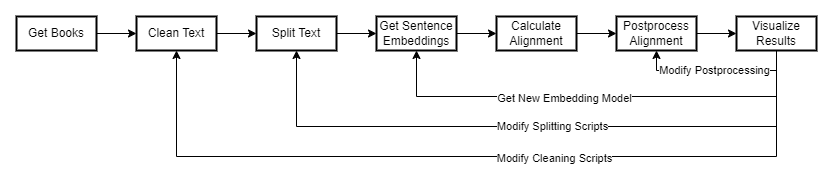

By visualizing the result, you can evaluate which steps in the pipeline can be improved, which is also indicated in the diagram.

## Prerequisites

- `py-gutenberg` and `requests` - for getting books
- `pysbd` - for split sentences
- `transformers[torch]` and `openvino_dev` - for getting sentence embeddings
- `seaborn` - for alignment matrix visualization

In [1]:
!pip install -q py-gutenberg requests pysbd transformers[torch] openvino_dev>=2023.0 seaborn

## Get Books

First step is to get books that we will be working with. For this notebook we will use english and german versions of Anna Karenina by Leo Tolstoy. The texts can be obtained from [Project Gutenberg site](https://www.gutenberg.org/). Since the copyright laws are complicated and differ from country to country, check if the book is legal to obtain in your country. You can start with Project Gutenberg Permissions, Licensing and other Common Requests [page](https://www.gutenberg.org/policy/permission.html).

First one needs to find a books on a Project Gutenberg [search page](https://www.gutenberg.org/ebooks/) and get the each book id. To get the texts we will pass ids to the [py-gutenberg](https://pypi.org/project/py-gutenberg/) library.

In [2]:
import requests
from gutenberg import GutenbergAPI


def get_book_by_id(book_id: int, api: GutenbergAPI = GutenbergAPI()) -> str:
    book_metadata = api.get_book_text(book_id)
    book_url = book_metadata.formats["text/plain"]
    return requests.get(book_url).text


en_book_id = 1399
de_book_id = 44956

anna_karenina_en = get_book_by_id(en_book_id)
anna_karenina_de = get_book_by_id(de_book_id)

In [3]:
anna_karenina_en[:1500]

'\ufeffThe Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy\r\n\r\nThis eBook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this eBook or online at\r\nwww.gutenberg.org. If you are not located in the United States, you\r\nwill have to check the laws of the country where you are located before\r\nusing this eBook.\r\n\r\nTitle: Anna Karenina\r\n\r\nAuthor: Leo Tolstoy\r\n\r\nRelease Date: July 1, 1998 [eBook #1399]\r\n[Most recently updated: April 9, 2023]\r\n\r\nLanguage: English\r\n\r\n\r\nProduced by: David Brannan, Andrew Sly and David Widger\r\n\r\n*** START OF THE PROJECT GUTENBERG EBOOK ANNA KARENINA ***\r\n\r\n[Illustration]\r\n\r\n\r\n\r\n\r\n ANNA KARENINA \r\n\r\n by Leo Tolstoy \r\n\r\n Translated by Constance Garnett \r\n\r\nContents\r\n\r\n\r\n PART ONE\r\

In [4]:
anna_karenina_de[:1500]

'\ufeffThe Project Gutenberg EBook of Anna Karenina, 1. Band, by Leo N. Tolstoi\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  You may copy it, give it away or\r\nre-use it under the terms of the Project Gutenberg License included\r\nwith this eBook or online at www.gutenberg.org\r\n\r\n\r\nTitle: Anna Karenina, 1. Band\r\n\r\nAuthor: Leo N. Tolstoi\r\n\r\nRelease Date: February 18, 2014 [EBook #44956]\r\n\r\nLanguage: German\r\n\r\n\r\n*** START OF THIS PROJECT GUTENBERG EBOOK ANNA KARENINA, 1. BAND ***\r\n\r\n\r\n\r\n\r\nProduced by Norbert H. Langkau, Jens Nordmann and the\r\nOnline Distributed Proofreading Team at http://www.pgdp.net\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n                             Anna Karenina.\r\n\r\n\r\n                        Roman aus dem Russischen\r\n\r\n                                  des\r\n\r\n                         Grafen Leo N. Tolstoi.\r\n\r\n\r\n\r\n                  Nach der siebe

## Clean Text

If you open the downloaded books, you'll see that there is some service information before and after the actual text. There are different formatting styles and some markup, for example when the author uses phrases from a different language, these phrases are enclosed with underscores (probably to italicize them):

>  Yes, Alabin was giving a dinner on glass tables, and the
tables sang, _Il mio tesoro_—not _Il mio tesoro_ though, but something
better, and there were some sort of little decanters on the table, and
they were women, too,” he remembstrics.

The next stages of the pipeline will be difficult to complete without cleaning and normalizing the text. Specific formatting may differ from case to case, so manual work is required at this stage. For example, the actual content in the German version is enclosed in `*       *       *       *       *`, so it is safe to remove everything before the first and after the last astrics.

> **Hint**: There are text-cleaning libraries that clean up common flaws. If the source of the text is known, as in our case, you can look for a library that works with texts from there, for example [`gutenberg_cleaner`](https://github.com/kiasar/gutenberg_cleaner). This will reduce the amount of manual work, or even automate the process.

In [5]:
import re
from contextlib import contextmanager
from tqdm.auto import tqdm


start_pattern_en = r"\nPART ONE"
anna_karenina_en = re.split(start_pattern_en, anna_karenina_en)[1].strip()

end_pattern_en = "*** END OF THE PROJECT GUTENBERG EBOOK ANNA KARENINA ***"
anna_karenina_en = anna_karenina_en.split(end_pattern_en)[0].strip()

In [6]:
start_pattern_de = "*       *       *       *       *"
anna_karenina_de = anna_karenina_de.split(start_pattern_de, maxsplit=1)[1].strip()
anna_karenina_de = anna_karenina_de.rsplit(start_pattern_de, maxsplit=1)[0].strip()

In [7]:
anna_karenina_en = anna_karenina_en.replace("\r\n", "\n")
anna_karenina_de = anna_karenina_de.replace("\r\n", "\n")

For this notebook, we will work only with the first chapter. Let's cut it out of the rest of the text and define some cleaning functions.

In [8]:
chapter_pattern_en = r"Chapter \d?\d"
chapter_1_en = re.split(chapter_pattern_en, anna_karenina_en)[1].strip()

In [9]:
anna_karenina_de[:1000]

'Erster Teil.\n\n                               »Die Rache ist mein, ich will vergelten.«\n\n                                   1.\n\n\nAlle glücklichen Familien sind einander ähnlich; jede unglückliche\nFamilie ist auf _ihre_ Weise unglücklich. --\n\nIm Hause der Oblonskiy herrschte allgemeine Verwirrung. Die Dame des\nHauses hatte in Erfahrung gebracht, daß ihr Gatte mit der im Hause\ngewesenen französischen Gouvernante ein Verhältnis unterhalten, und ihm\nerklärt, sie könne fürderhin nicht mehr mit ihm unter einem Dache\nbleiben. Diese Situation währte bereits seit drei Tagen und sie wurde\nnicht allein von den beiden Ehegatten selbst, nein auch von allen\nFamilienmitgliedern und dem Personal aufs Peinlichste empfunden. Sie\nalle fühlten, daß in ihrem Zusammenleben kein höherer Gedanke mehr\nliege, daß die Leute, welche auf jeder Poststation sich zufällig träfen,\nnoch enger zu einander gehörten, als sie, die Glieder der Familie\nselbst, und das im Hause geborene und aufgewachsene G

In [10]:
chapter_pattern_de = r"\d?\d.\n\n"
chapter_1_de = re.split(chapter_pattern_de, anna_karenina_de)[1].strip()

In [11]:
def remove_single_newline(text: str) -> str:
    return re.sub(r"\n(?!\n)", " ", text)

def unify_quotes(text: str) -> str:
    return re.sub(r"['\"»«“”]", '"', text)

def remove_markup(text: str) -> str:
    text = text.replace(">=", "").replace("=<", "")
    return re.sub(r"_\w|\w_", "", text)

Gather cleaning functions into a single pipeline. To track the progress of the execution, the `tqdm` library is used. Define a context manager that will allow you to turn off progress indicators if they are not needed.

In [12]:
disable_tqdm = False

@contextmanager
def disable_tqdm_context():
    global disable_tqdm
    disable_tqdm = True
    yield
    disable_tqdm = False


text_cleaning_pipeline = [
    remove_single_newline,
    unify_quotes,
    remove_markup,
]

def clean_text(text: str) -> str:
    progress_bar = tqdm(text_cleaning_pipeline, disable=disable_tqdm)
    for clean_func in progress_bar:
        progress_bar.set_postfix_str(clean_func.__name__)
        text = clean_func(text)
    return text

chapter_1_en = clean_text(chapter_1_en)
chapter_1_de = clean_text(chapter_1_de)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Split Text

Dividing text into sentences is not as easy a task as it might seem at first glance. The problem is called [sentence boundary disambiguation](https://en.wikipedia.org/wiki/Sentence_boundary_disambiguation), and is solved with heuristics or machine learning models. The notebook uses a `Segmenter` from the `pysbd` library, which is initialized with an [ISO language code](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes) - for different languages, the set of rules for splitting text into sentences may differ.

> **Hint**: the `book_metadata` we get from the `GutenbergAPI` contains the language code as well, so this part of the pipeline can also be automated.

In [13]:
import pysbd


splitter_en = pysbd.Segmenter(language="en", clean=True)
splitter_de = pysbd.Segmenter(language="de", clean=True)


sentences_en = splitter_en.segment(chapter_1_en)
sentences_de = splitter_de.segment(chapter_1_de)

len(sentences_en), len(sentences_de)

(32, 34)

## Get Sentence Embeddings

The next step is to transform sentences into vector representations. Transformer encoder models, such as BERT, provide the best quality embeddings but can be quite slow. Another aspect is that the model should support both of our chosen languages. In practice, it is quite expensive to train a separate model for each language pair, so there are quite a lot of models pre-trained on multiple languages simultaneously, for example:

- multilingual-MiniLM ([example](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2))
- distiluse-base-multilingual-cased ([example](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2))
- bert-base-multilingual-uncased ([example](https://huggingface.co/bert-base-multilingual-uncased))
- LaBSE ([example](https://huggingface.co/rasa/LaBSE))

LaBSE stands for [Language-agnostic BERT Sentence Embedding](https://arxiv.org/pdf/2007.01852.pdf) and supports 109+ languages. It has the same architecture, as BERT model, but was trained on different task - to produce the same embeddings for the translation pair.
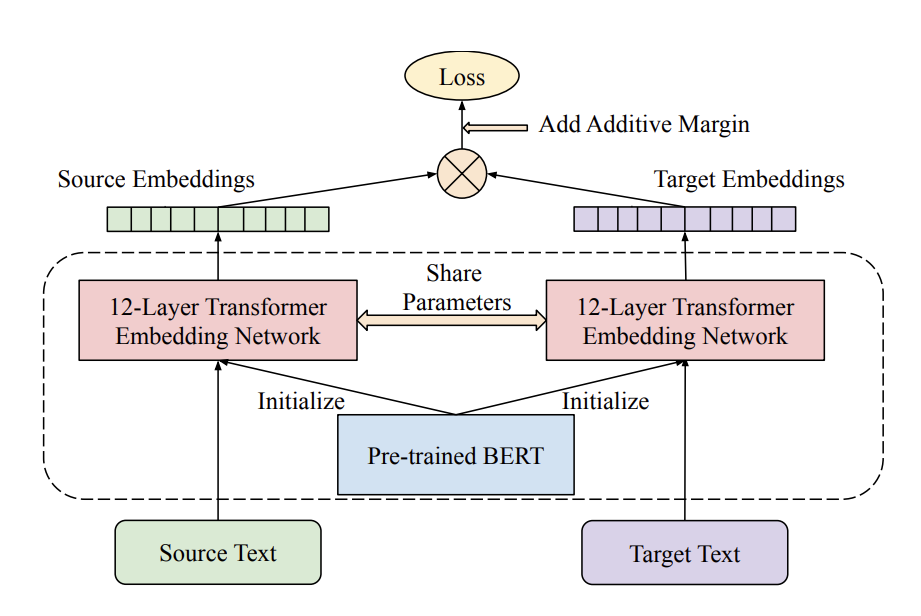

This makes LaBSE a great choice for our task. Moreover, the model can be reused for different language pair and still produce good results. 

In [14]:
from typing import List, Union, Dict
from transformers import AutoTokenizer, AutoModel, BertModel
import numpy as np
import torch
from openvino.runtime import CompiledModel as OVModel


model_id = "rasa/LaBSE"
pt_model = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

The model has two outputs - `last_hidden_state` and `pooler_output`. As a proposal embedding, you can use either the first vector from the `last_hidden_state`, which corresponds to the special `[CLS]` token, or the entire vector from the second input. The second option is usually used, but the first one works well for our task too. Fill free to experiment with different outputs.

In [30]:
def get_embeddings(
    sentences: List[str], 
    embedding_model: Union[BertModel, OVModel],
) -> np.ndarray:
    if isinstance(embedding_model, OVModel):
        embeddings = [
            embedding_model(tokenizer(sent, return_tensors="np").data)["last_hidden_state"][0][0]
            for sent in tqdm(sentences, disable=disable_tqdm)
        ]
        return np.vstack(embeddings)
    else:
        embeddings = [
            embedding_model(**tokenizer(sent, return_tensors="pt"))["last_hidden_state"][0][0]
            for sent in tqdm(sentences, disable=disable_tqdm)
        ]
        return torch.vstack(embeddings)


embeddings_en_pt = get_embeddings(sentences_en, pt_model)
embeddings_de_pt = get_embeddings(sentences_de, pt_model)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

### Get Embeddings with OpenVINO Model


The LaBSE model is quite large and can be slow to infer on some hardware, so let's optimize it with OpenVINO. [Model Optimizer's Python API](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) accept the Pytorch/Transformers model object and additional information about model inputs. `example_input` is needed to trace the model execution graph, since the PyTorch constructs it dynamically during inference.

In [31]:
from openvino.runtime import Core, Type
from openvino.tools.mo import convert_model


 # 3 inputs with dynamic axis [batch_size, sequence_length]
inputs_info = [([-1, -1], Type.i64)] * 3 
ov_model = convert_model(
    pt_model,
    example_input=tokenizer("test", return_tensors="pt").data,
    input=inputs_info,
)

core = Core()
compiled_model = core.compile_model(ov_model, "CPU")

embeddings_en = get_embeddings(sentences_en, compiled_model)
embeddings_de = get_embeddings(sentences_de, compiled_model)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Using Intel Core i9-10980XE CPU PyTorch model was able to process 40-43 sentences per second, while the same model converted to OpenVINO processed 56-60 sentences per second. This is about 40% performance boost with just a few lines of code. Let's check if the model predictions stay within acceptable tolerance:

In [32]:
np.all(np.isclose(embeddings_en, embeddings_en_pt.detach().numpy(), atol=1e-3))

True

## Calculate Sentence Alignment

With the embedding matrices from the previous step, we can calculate the alignment:
1. Calculate sentence similarity between each pair of sentences
1. Transform values in the similarity matrix rows and columns so that they are in a specified range, for example `[-1, 1]`
1. Compare the values with some threshold to get boolean matrices with 0 and 1
1. Sentence pairs that have 1 in both matrices should be aligned according to the model

We visualize the resulting matrix and also make sure that the result of the converted model is the same as the original one.

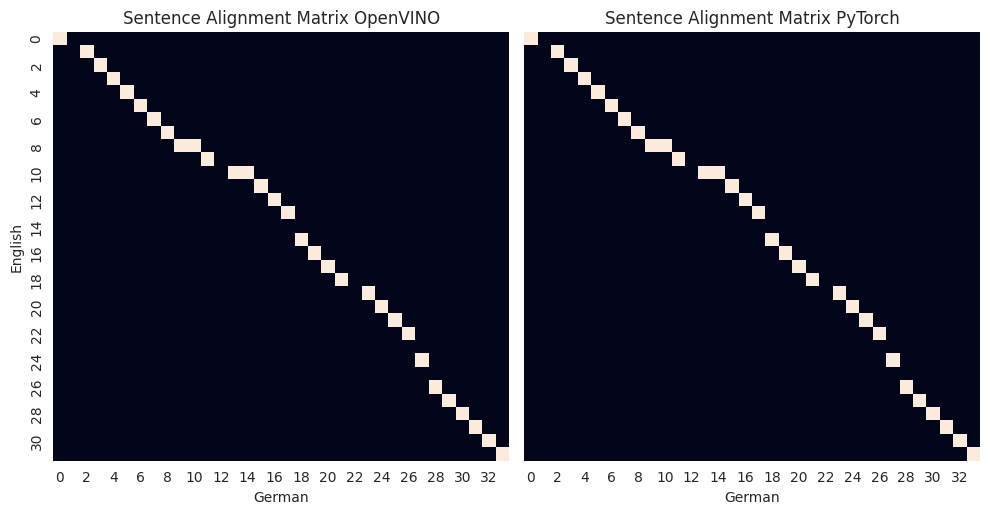

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")

def transform(x):
    x = x - np.mean(x)
    return x / np.var(x)


def calculate_alignment_matrix(first: np.ndarray, second: np.ndarray, threshold: float = 1e-3) -> np.ndarray:
    similarity = first @ second.T  # 1
    similarity_en_to_de = np.apply_along_axis(transform, -1, similarity)  # 2
    similarity_de_to_en = np.apply_along_axis(transform, -2, similarity)  # 2

    both_one = (similarity_en_to_de > threshold) * (similarity_de_to_en > threshold)  # 3 and 4
    return both_one


threshold = 0.028

alignment_matrix = calculate_alignment_matrix(embeddings_en, embeddings_de, threshold)
alignment_matrix_pt = calculate_alignment_matrix(
    embeddings_en_pt.detach().numpy(), 
    embeddings_de_pt.detach().numpy(), 
    threshold,
)

graph, axis = plt.subplots(1, 2,  figsize=(10, 5), sharey=True)

for matrix, ax, title in zip(
    (alignment_matrix, alignment_matrix_pt), axis, ("OpenVINO", "PyTorch")
):
    plot = sns.heatmap(matrix, cbar=False, square=True, ax=ax)
    plot.set_title(f"Sentence Alignment Matrix {title}")
    plot.set_xlabel("German")
    if title == "OpenVINO":
        plot.set_ylabel("English")
        
graph.tight_layout()

Transform the matrix into a dictionary for further visualization:

In [34]:
def make_alignment(alignment_matrix: np.ndarray) -> Dict[int, List[int]]:
    aligned = {idx: [] for idx, sent in enumerate(sentences_en)}
    for en_idx, de_idx in zip(*np.nonzero(alignment_matrix)):
        aligned[en_idx].append(de_idx)
    return aligned

aligned = make_alignment(alignment_matrix)
aligned

{0: [0],
 1: [2],
 2: [3],
 3: [4],
 4: [5],
 5: [6],
 6: [7],
 7: [8],
 8: [9, 10],
 9: [11],
 10: [13, 14],
 11: [15],
 12: [16],
 13: [17],
 14: [],
 15: [18],
 16: [19],
 17: [20],
 18: [21],
 19: [23],
 20: [24],
 21: [25],
 22: [26],
 23: [],
 24: [27],
 25: [],
 26: [28],
 27: [29],
 28: [30],
 29: [31],
 30: [32],
 31: [33]}

## Postprocess Sentence Alignment

There are several gaps in the resulting alignment. For example, English sentence \#14 did not map to any German one. Possible reasons are:

1. There are no equivalent sentences in the other book. In this case, the model works correctly.
1. The sentence has an equivalent sentence in another language, but the model did not catch that. The `threshold` might be too high, or the model is not sensitive enough. Lower the `threshold` value or try a different model.
1. The sentence has an equivalent text part in another language. That means that one of the sentence splitters is working too fine or too coarse. Tune text cleaning and splitting steps to fix this issue.
1. Combination of 2 and 3.

Another solution is to fix the problem by agreeing with some heuristics. As you can see, English sentence 13 corresponds to German 17, and 15 to 18. Most likely English 14 is part of German 17 or 18, and you can choose the right one by comparing the similarity using the model.

## Visualize Sentence Alignment

To evaluate the final alignment and choose the best way to improve the results of the pipeline, we will create an interactive table with HTML and JS.

In [35]:
from IPython.display import display, HTML
from itertools import zip_longest
from io import StringIO


def create_interactive_table(list1: List[str], list2: List[str], mapping: Dict[int, List[int]]) -> str:
    def inverse_mapping(mapping):
        inverse_map = {idx: [] for idx in range(len(list2))}

        for key, values in mapping.items():
            for value in values:
                inverse_map[value].append(key)

        return inverse_map
    
    inversed_mapping = inverse_mapping(mapping)
    
    table_html = StringIO()
    table_html.write('<table id="mappings-table"><tr><th>Sentences EN</th><th>Sentences DE</th></tr>')
    for i, (first, second) in enumerate(zip_longest(list1, list2)):
        table_html.write("<tr>")
        if i < len(list1):
            table_html.write(f'<td id="list1-{i}">{first}</td>')
        else:
            table_html.write("<td></td>")
        if i < len(list2):
            table_html.write(f'<td id="list2-{i}">{second}</td>')
        else:
            table_html.write("<td></td>")
        table_html.write("</tr>")

    table_html.write("</table>")

    hover_script = """
    <script type="module">
      const highlightColor = '#0054AE';
      const textColor = 'white'
      const mappings = {
        'list1': """ + str(mapping) + """,
        'list2': """ + str(inversed_mapping) + """
      };

      const table = document.getElementById('mappings-table');
      let highlightedIds = [];

      table.addEventListener('mouseover', ({ target }) => {
        if (target.tagName !== 'TD' || !target.id) {
          return;
        }

        const [listName, listId] = target.id.split('-');
        const mappedIds = mappings[listName]?.[listId]?.map((id) => `${listName === 'list1' ? 'list2' : 'list1'}-${id}`) || [];
        const idsToHighlight = [target.id, ...mappedIds];

        setBackgroud(idsToHighlight, highlightColor, textColor);
        highlightedIds = idsToHighlight;
      });

      table.addEventListener('mouseout', () => setBackgroud(highlightedIds, ''));

      function setBackgroud(ids, color, text_color="unset") {
        ids.forEach((id) => {
            document.getElementById(id).style.backgroundColor = color;
            document.getElementById(id).style.color = text_color
        });
      }
    </script>
    """
    table_html.write(hover_script)
    return table_html.getvalue()

In [36]:
html_code = create_interactive_table(sentences_en, sentences_de, aligned)
display(HTML(html_code))

Sentences EN,Sentences DE
Happy families are all alike; every unhappy family is unhappy in its own way.,Alle glücklichen Familien sind einander ähnlich; jede unglückliche Familie ist auf hr Weise unglücklich.
Everything was in confusion in the Oblonskys’ house.,--
"The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on living in the same house with him.",Im Hause der Oblonskiy herrschte allgemeine Verwirrung.
"This position of affairs had now lasted three days, and not only the husband and wife themselves, but all the members of their family and household, were painfully conscious of it.","Die Dame des Hauses hatte in Erfahrung gebracht, daß ihr Gatte mit der im Hause gewesenen französischen Gouvernante ein Verhältnis unterhalten, und ihm erklärt, sie könne fürderhin nicht mehr mit ihm unter einem Dache bleiben."
"Every person in the house felt that there was no sense in their living together, and that the stray people brought together by chance in any inn had more in common with one another than they, the members of the family and household of the Oblonskys.","Diese Situation währte bereits seit drei Tagen und sie wurde nicht allein von den beiden Ehegatten selbst, nein auch von allen Familienmitgliedern und dem Personal aufs Peinlichste empfunden."
"The wife did not leave her own room, the husband had not been at home for three days.","Sie alle fühlten, daß in ihrem Zusammenleben kein höherer Gedanke mehr liege, daß die Leute, welche auf jeder Poststation sich zufällig träfen, noch enger zu einander gehörten, als sie, die Glieder der Familie selbst, und das im Hause geborene und aufgewachsene Gesinde der Oblonskiy."
"The children ran wild all over the house; the English governess quarreled with the housekeeper, and wrote to a friend asking her to look out for a new situation for her; the man-cook had walked off the day before just at dinner time; the kitchen-maid, and the coachman had given warning.","Die Herrin des Hauses verließ ihre Gemächer nicht, der Gebieter war schon seit drei Tagen abwesend."
"Three days after the quarrel, Prince Stepan Arkadyevitch Oblonsky—Stiva, as he was called in the fashionable world—woke up at his usual hour, that is, at eight o’clock in the morning, not in his wife’s bedroom, but on the leather-covered sofa in his study.","Die Kinder liefen wie verwaist im ganzen Hause umher, die Engländerin schalt auf die Wirtschafterin und schrieb an eine Freundin, diese möchte ihr eine neue Stellung verschaffen, der Koch hatte bereits seit gestern um die Mittagszeit das Haus verlassen und die Köchin, sowie der Kutscher hatten ihre Rechnungen eingereicht."
"He turned over his stout, well-cared-for person on the springy sofa, as though he would sink into a long sleep again; he vigorously embraced the pillow on the other side and buried his face in it; but all at once he jumped up, sat up on the sofa, and opened his eyes.","Am dritten Tage nach der Scene erwachte der Fürst Stefan Arkadjewitsch Oblonskiy -- Stiwa hieß er in der Welt -- um die gewöhnliche Stunde, das heißt um acht Uhr morgens, aber nicht im Schlafzimmer seiner Gattin, sondern in seinem Kabinett auf dem Saffiandiwan."
"""Yes, yes, how was it now?"" he thought, going over his dream.","Er wandte seinen vollen verweichlichten Leib auf den Sprungfedern des Diwans, als wünsche er noch weiter zu schlafen, während er von der andern Seite innig ein Kissen umfaßte und an die Wange drückte."


You can see that the pipeline does not clean up the German text completely, which is why, for example, the second sentence consists of only `--`. On a positive note, the split sentences in the German translation line up correctly with the single English sentence. The pipeline already works well, but there is room for improvement.

Save the OpenVINO model to disk for future use:

In [37]:
from openvino.runtime import serialize


ov_model_path = "ov_model/model.xml"
serialize(ov_model, ov_model_path)

To read the model from disk use the `read_model` method of the `Core` object:

In [38]:
ov_model = core.read_model(ov_model_path)

## Speed Up Embeddings Computation

Let's see how we can speed up the most computationally complex part of the pipeline - getting embeddings. The question may arise why, when using OpenVINO, after reading the model, you need to compile it. There are two main reasons for this:
1. The model can be compiled to run on a [specific device](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_Working_with_devices.html) - CPU, GPU or GNA. Different devices can work with different types of data, support different sets of features, and can also gain performance by changing the neural network for a specific computing model. With OpenVINO, you do not need to store several copies of the network with optimizations for specific hardware, a universal IR is enough.
1. In addition to optimization for specific hardware, the model can be optimized for different scenarios. In one case, it is required that the _time between the start and end of the inference_ of the model be minimal - this scenario is called [**latency**](https://docs.openvino.ai/2023.0/openvino_docs_deployment_optimization_guide_latency.html) oriented optimization. In our case, it is more important _how many texts per second the model can process_ - these are [**throughput**](https://docs.openvino.ai/2023.0/openvino_docs_deployment_optimization_guide_tput.html) optimizations.

To get a throughput-optimized model pass a [performance hint](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_Performance_Hints.html#performance-hints-latency-and-throughput) as a configuration during compilation so that OpenVINO selects the optimal parameters for execution on available hardware.

In [39]:
from openvino.runtime import Core, AsyncInferQueue, InferRequest
from typing import Any


compiled_throughput_hint = core.compile_model(
    ov_model,
    device_name="CPU",
    config={"PERFORMANCE_HINT":"THROUGHPUT"},
)

Let's change the inference mode from Sync to Async to get even more hardware utilisation. Although the synchronous API can be easier to start with, it is [recommended](https://docs.openvino.ai/2022.1/openvino_docs_deployment_optimization_guide_common.html#prefer-openvino-async-api) to use the asynchronous (callbacks-based) API in production code. It is the most general and scalable way to implement flow control for any possible number of requests.

To output in asynchronous mode, you need to define two things:

1. Instantiate an `AsyncInferQueue`, which can then be populated with inference requests.
1. Define a `callback` function that will be called after the output request has been executed and its results have been processed.
 
In addition to the model input, any data that is needed for post-processing can be passed to the queue. We can create a zero embedding matrix in advance and we will fill it in as the inference requests are executed.

In [40]:
def get_embeddings_async(sentences: List[str], embedding_model: OVModel) -> np.ndarray:
    def callback(infer_request: InferRequest, user_data: List[Any]) -> None:
        embeddings, idx, pbar = user_data
        embedding = infer_request.get_output_tensor(0).data[0, 0]
        embeddings[idx] = embedding
        pbar.update()


    infer_queue = AsyncInferQueue(embedding_model)
    infer_queue.set_callback(callback)

    embedding_dim = embedding_model.output(0).get_partial_shape().get_dimension(2).get_length()
    embeddings = np.zeros((len(sentences), embedding_dim))
    
    with tqdm(total=len(sentences), disable=disable_tqdm) as pbar:
        for idx, sent in enumerate(sentences):
            tokenized = tokenizer(sent, return_tensors="np").data

            infer_queue.start_async(
                tokenized,
                [embeddings, idx, pbar]
            )

        infer_queue.wait_all()

    return embeddings

Compare models and plot the results.

> **Note**: to get a more accurate benchmark, use the [Benchmark Python Tool](https://docs.openvino.ai/2022.1/openvino_inference_engine_tools_benchmark_tool_README.html)

In [41]:
number_of_chars = 15_000
more_sentences_en = splitter_en.segment(clean_text(anna_karenina_en[:number_of_chars]))
len(more_sentences_en)

  0%|          | 0/3 [00:00<?, ?it/s]

112

In [42]:
import pandas as pd
from time import perf_counter


benchmarks = [
    (pt_model, get_embeddings, "PyTorch"),
    (compiled_model, get_embeddings, "OpenVINO\nSync"),
    (compiled_throughput_hint, get_embeddings_async, "OpenVINO\nThroughput Hint\nAsync"),
]

number_of_sentences = 100
benchmark_data = more_sentences_en[:min(number_of_sentences, len(more_sentences_en))]

benchmark_results = {name: [] for *_, name in benchmarks}

benchmarks_iterator = tqdm(benchmarks, leave=False, disable=disable_tqdm)
for model, func, name in benchmarks_iterator:
    printable_name = name.replace("\n", " ")
    benchmarks_iterator.set_description(f"Run benchmark for {printable_name} model")
    for run in tqdm(range(10 + 1), leave=False, desc="Benchmark Runs: ", disable=disable_tqdm):
        with disable_tqdm_context():
            start = perf_counter()
            func(benchmark_data, model)
            end = perf_counter()
        benchmark_results[name].append(len(benchmark_data) / (end - start))

benchmark_dataframe = pd.DataFrame(benchmark_results)[1:]

  0%|          | 0/3 [00:00<?, ?it/s]

Benchmark Runs:   0%|          | 0/11 [00:00<?, ?it/s]

Benchmark Runs:   0%|          | 0/11 [00:00<?, ?it/s]

Benchmark Runs:   0%|          | 0/11 [00:00<?, ?it/s]

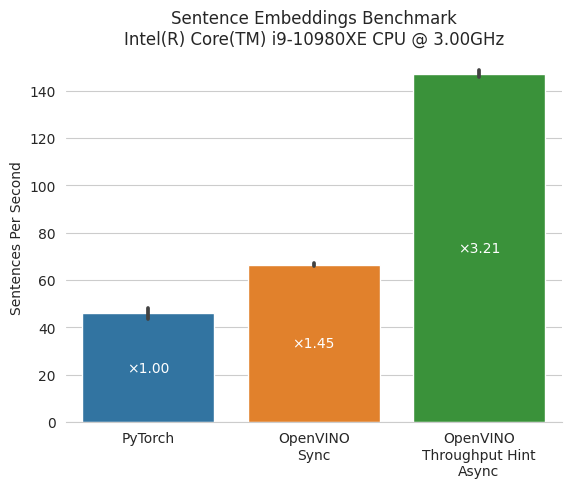

In [43]:
cpu_name = core.get_property("CPU", "FULL_DEVICE_NAME")

plot = sns.barplot(benchmark_dataframe, errorbar="sd")
plot.set(
    ylabel="Sentences Per Second", 
    title=f"Sentence Embeddings Benchmark\n{cpu_name}"
)
perf_ratio = (
    benchmark_dataframe.mean() / benchmark_dataframe.mean()[0]
)
plot.bar_label(
    plot.containers[0], 
    labels=[f"×{ratio:.2f}" for ratio in perf_ratio], 
    color="white",
    label_type="center",
)
plot.spines['right'].set_visible(False)
plot.spines['top'].set_visible(False)
plot.spines['left'].set_visible(False)